# Q4: How does CCM respond to relaxation of A1: C contain information about S

I'm going to include $\tilde{C} = [C, \text{onehot}(S)]$

In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn.metrics import average_precision_score
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform, shortcut_noise_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

In [40]:
def get_error(p, n=100):
    '''bootstrap'''
    assert 0 <= p <= 1, "probablity is non-negative"
    n_test = 5790 # number of test data in cub
    a, b = np.percentile([sum(np.random.choice(2, n_test, p=[1-p, p])) / float(n_test) for _ in range(n)], [2.5, 97.5])
    return a, b

def plot_d_noise(d, dim=0, label=None, alpha=1):
    x = d.keys()
    y = list(map(lambda x: x[dim], d.values()))
    # plt.plot(x, y, label=label)
    # yerr = list(zip(*[get_error(a/100.0) for a in y]))
    yerr = list(zip(*[list(map(lambda i: abs(i-a/100.0) * 100, get_error(a/100.0))) for a in y]))
    # print(len(yerr), len(yerr[0]), yerr)
    plt.errorbar(x, y, yerr=yerr, label=label, alpha=alpha)
    


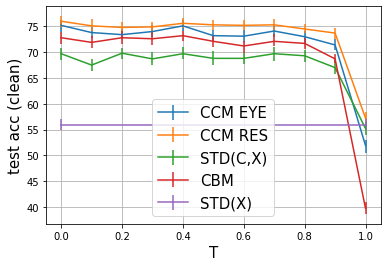

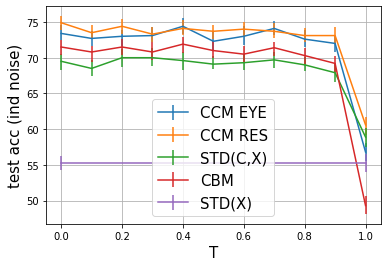

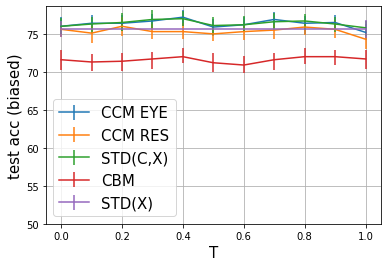

In [42]:
# key is threshold_concept, value is [clean acc, t=0, t=1]
perf_dict_cbm = {
    0: [72.8, 71.5, 71.6],
    0.1: [71.9, 70.8, 71.3],
    0.2: [72.8, 71.5, 71.4],
    0.3: [72.6, 70.8, 71.7],
    0.4: [73.2, 71.9, 72.0],
    0.5: [72.1, 71.0, 71.2],
    0.6: [71.2, 70.5, 70.9],
    0.7: [72.1, 71.4, 71.6],
    0.8: [71.7, 70.3, 72.0],
    0.9: [68.7, 69.2, 72.0],
    1.0: [39.7, 49.3, 71.7],
}
perf_dict_eye = { # currently only tried 1e-3
    0: [75.2, 73.4, 76.0],
    0.1: [73.8, 72.7, 76.4],
    0.2: [73.4, 73.0, 76.4],
    0.3: [74.0, 73.1, 76.7],
    0.4: [75.1, 74.4, 77.2],
    0.5: [73.2, 72.3, 75.9],
    0.6: [73.1, 73.0, 76.2],
    0.7: [74.1, 74.1, 76.9],
    0.8: [73.0, 72.6, 76.4],
    0.9: [71.4, 72.0, 76.5],
    1.0: [51.9, 56.8, 75.2],
}
perf_dict_stdcx = { # eye with alpha=0
    0: [69.7, 69.5, 76.0], 
    0.1: [67.5, 68.5, 76.3],
    0.2: [69.8, 70.0, 76.5],
    0.3: [68.7, 70.0, 76.9],
    0.4: [69.7, 69.6, 77.0],
    0.5: [68.8, 69.1, 76.1],
    0.6: [68.8, 69.3, 76.2],
    0.7: [69.7, 69.7, 76.6],
    0.8: [69.3, 69.0, 76.7],
    0.9: [67.0, 67.9, 76.3],
    1.0: [55.2, 58.9, 75.8],
}
perf_dict_ccmr = {
    0: [76.0, 74.9, 75.6],
    0.1: [75.1, 73.5, 75.1],
    0.2: [74.8, 74.4, 76.0],
    0.3: [74.9, 73.3, 75.3],
    0.4: [75.6, 74.1, 75.3],
    0.5: [75.3, 73.7, 75.0],
    0.6: [75.2, 74.0, 75.3],
    0.7: [75.3, 73.7, 75.5],
    0.8: [74.5, 73.1, 75.9],
    0.9: [73.7, 73.1, 75.6],
    1.0: [57.2, 60.6, 74.3], 
}
perf_dict_stdx = { # don't change in this setup
    0: [55.8, 55.2, 75.7], 
    1: [55.8, 55.2, 75.7],
}

xlabel = "T" #"probability S is dependent of X"

plot_d_noise(perf_dict_eye, 0, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 0, "CCM RES")
plot_d_noise(perf_dict_stdcx, 0, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 0, "CBM")
plot_d_noise(perf_dict_stdx, 0, "STD(X)")
plt.ylabel('test acc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
# plt.savefig('figures/clean_t_cub.png')
plt.show()

plot_d_noise(perf_dict_eye, 1, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 1, "CCM RES")
plot_d_noise(perf_dict_stdcx, 1, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 1, "CBM")
plot_d_noise(perf_dict_stdx, 1, "STD(X)")
plt.ylabel('test acc (ind noise)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
# plt.savefig('figures/ind_t_cub.png')
plt.show()

plot_d_noise(perf_dict_eye, 2, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 2, "CCM RES")
plot_d_noise(perf_dict_stdcx, 2, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 2, "CBM")
plot_d_noise(perf_dict_stdx, 2, "STD(X)")
plt.ylabel('test acc (biased)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.ylim(50)
plt.grid()
# plt.savefig('figures/bias_t_cub.png')
plt.show()

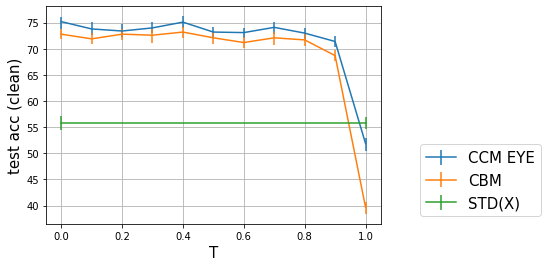

In [47]:
plot_d_noise(perf_dict_eye, 0, "CCM EYE", alpha=1)
# plot_d_noise(perf_dict_ccmr, 0, "CCM RES")
# plot_d_noise(perf_dict_stdcx, 0, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 0, "CBM", alpha=1)
plot_d_noise(perf_dict_stdx, 0, "STD(X)")
plt.ylabel('test acc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.5, 0.4))
plt.grid()
plt.show()


In [8]:
print(get_error(55.8/100))
print(get_error(75.7/100))


(0.5452504317789292, 0.5702115716753022)
(0.7487046632124352, 0.7714205526770294)


# Q5: How does CCM respond to relaxation of A2: S contain information outside of C

Instead of using cbm for shortcut, this time just use noise but break it down; this setting fixes C but increases importance of S; this test when S contain information outside of U and C

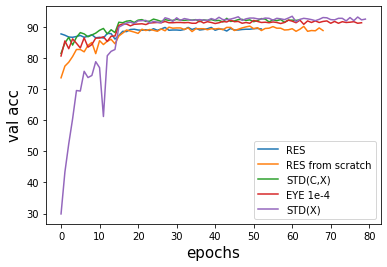

In [3]:
key = 'val acc' # 'train acc' #'val acc'
plot_log(torch.load("../outputs/relaxSinC1.0/59e7c2961bf711ecb773ac1f6b24a434/ccm.log"), key=key, label="RES")
plot_log(torch.load("../outputs/16ff59821d7611ecb773ac1f6b24a434/ccm.log"), key=key, label="RES from scratch")
plot_log(torch.load("../outputs/relaxSinC1.0/d02345561bee11ecb773ac1f6b24a434/ccm.log"), key=key, label="STD(C,X)")
plot_log(torch.load("../outputs/relaxSinC1.0/afc8e0841cfe11ecb773ac1f6b24a434/ccm.log"), key=key, label="EYE 1e-4")
plot_log(torch.load("../outputs/relaxSinC1.0/87f4e850e36f11ebb773ac1f6b24a434/standard.log"), key=key, label="STD(X)")
# plot_log(torch.load("../outputs/relaxSinC1.0/0611ac121c0211ecb773ac1f6b24a434/ccm.log"), key=key, label="EYE 1e-3")
# plot_log(torch.load("../outputs/103363461d7111ecb773ac1f6b24a434/ccm.log"), key=key, label="RES wd=4e-3")

plt.legend()
# plt.ylim(98)
plt.show()


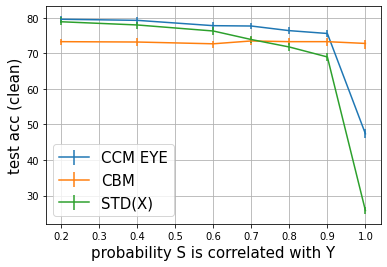

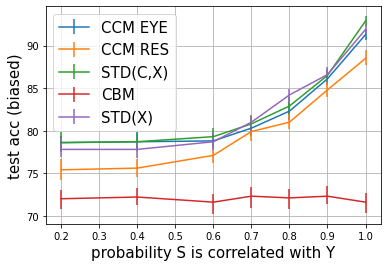

In [48]:
# key is percent noise, start from non-zero because 0 is not a shortcut, value is [clean acc, t=0, t=1]
# relaxSinC
perf_dict_cbm = { # don't change in this setup because 
    0.2: [73.3, None, 72.0],
    0.4: [73.2, None, 72.2],
    0.6: [72.7, None, 71.6],
    0.7: [73.5, None, 72.3],
    0.8: [73.3, None, 72.1],
    0.9: [73.3, None, 72.3],
    1.0: [72.8, 71.5, 71.6],
}
perf_dict_eye = { # currently only tried 1e-3, this is using wl2, right is 1e-4
    # 0: [75.2, 73.4, 76.0],
    0.2: [79.6, 78.3, 78.6], # [78.3, 77.3, 77.4], # 1e-3
    0.4: [79.3, 78.2, 78.7], # [78.4, 77.2, 77.8], # 1e-3
    0.6: [77.8, 76.9, 78.8],
    0.7: [77.7, 77.1, 80.3],
    0.8: [76.4, 75.6, 82.3], # [77.1, 76.3, 81.7], # 1e-3
    0.9: [75.6, 73.4, 86.1], # [76.6, 74.8, 83.1], # 1e-3
    1.0: [47.4, 51.5, 91.3], # [62.3, 60.9, 89.3], # 1e-3
}
perf_dict_stdcx = { # eye with alpha=0
    # 0: [69.7, 69.5, 76.0],
    0.2: [79.6, 78.3, 78.6],
    0.4: [79.3, 78.2, 78.7],
    0.6: [77.6, 76.8, 79.3],
    0.7: [77.5, 76.8, 80.8],
    0.8: [76, 74.9, 82.9],
    0.9: [74.8, 72.7, 86.5],
    1.0: [31.3, 33.9, 92.9],
}
perf_dict_ccmr = {
    # 0: [76.0, 74.9, 75.6],
    0.2: [76.7, 75.5, 75.4],
    # 0.2: [77, None, 76.2], # split valid
    0.4: [76.3, 75.4, 75.6],
    # 0.4: [73.9, None, 75.6], # split valid
    0.6: [75.8, 74.6, 77.1],
    # 0.6: [74.4, None, 78], # split valid
    0.7: [75.3, None, 79.9], #
    0.8: [74.9, 73.9, 81.0],
    # 0.8: [71.6, None, 81.7], # split valid
    0.9: [73.6, None, 84.8],
    1.0: [66.1, 62.1, 88.5],
}
perf_dict_stdx = {
    # 0: [55.8, 55.2, 75.7],
    0.2: [78.9, 77.6, 77.8],
    0.4: [78.0, 76.6, 77.8],
    0.6: [76.3, 75.1, 78.7],
    0.7: [73.9, 73.7, 81.0],
    0.8: [71.8, 70.9, 84.2],
    0.9: [69.0, 64.9, 86.6],
    1.0: [25.8, 30.8, 91.9],
}
    
xlabel = "probability S is correlated with Y"

plot_d_noise(perf_dict_eye, 0, "CCM EYE")
# plot_d_noise(perf_dict_ccmr, 0, "CCM RES")
# plot_d_noise(perf_dict_stdcx, 0, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 0, "CBM")
plot_d_noise(perf_dict_stdx, 0, "STD(X)")
plt.ylabel('test acc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
# plt.savefig('figures/clean_a2_cub.png')
plt.show()

# plot_d_noise(perf_dict_eye, 1, "CCM EYE")
# plot_d_noise(perf_dict_ccmr, 1, "CCM RES")
# plot_d_noise(perf_dict_stdcx, 1, "STD(C,X)")
# plot_d_noise(perf_dict_cbm, 1, "CBM")
# plot_d_noise(perf_dict_stdx, 1, "STD(X)")
# plt.ylabel('test acc (ind noise)', fontsize=15)
# plt.xlabel(xlabel, fontsize=15)
# plt.legend(fontsize=15)
# plt.grid()
# plt.savefig('figures/ind_a2_cub.png')
# plt.show()

plot_d_noise(perf_dict_eye, 2, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 2, "CCM RES")
plot_d_noise(perf_dict_stdcx, 2, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 2, "CBM")
plot_d_noise(perf_dict_stdx, 2, "STD(X)")
plt.ylabel('test acc (biased)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.grid()
# plt.savefig('figures/bias_a2_cub.png')
plt.show()

From left to right, Shortcut strength increases; 

As before, on ranges where shortcut is utilized by STD(X) (>0.6), CCM is consistently better than STD(X) as shortcut strength increases. However, when STD(X) and CBM have similar clean accuracy, CCM no longer has an edge over STD(C, X) as relying more on C won't make the model more robust.

When shortcut is strong, CCM RES initializes the model to trust more of CBM, which makes it much stronger than STD(C,X), but notice that it still performs worse than CBM as it needs to pick up S in order to achieve better predictive accuracy on the biased dataset.

One more noticeable thing is that CCM RES has a lowered accuracy than STD(X) on the biased dataset when shortcut is strong. CBM RES is indeed more prone to overfitting on the original dataset than baselines as it starts from CBM's solution while other methods starts from a solution near 0 (small norm solution). This lowered performance also affect its ability to be accurate on ranges in which shortcut is not picked up.

# Automation of the result

In [17]:
from collections import defaultdict
methods = ['CCM EYE', 'CCM RES', 'STD(C,X)', 'CBM', 'STD(X)']
results = {m: defaultdict(dict) for m in methods} # results[method][x][key]

In [37]:
dirnames = [ # dir, method, train_t
    # 0.9
    # # ('../outputs/relaxSinC0.9/73787fc81cf311ecb773ac1f6b24a434', methods[0], 0.9), # 1e-3
    ('../outputs/535cc7741d0911ecb773ac1f6b24a434', methods[0], 0.9), # 1e-4
    ('../outputs/relaxSinC0.9/38fc3398771211ec830e8fa97a4e8129', methods[1], 0.9),
    ('../outputs/relaxSinC0.9/8cc978a61ce911ecb773ac1f6b24a434', methods[2], 0.9),
    ('../outputs/relaxSinC0.9/9139e82a769a11ec830e8fa97a4e8129', methods[3], 0.9),
    ('../outputs/relaxSinC0.9/8ab4e3541c9211ecb773ac1f6b24a434', methods[4], 0.9),
    # 0.8
    ('../outputs/relaxSinC0.8/5677585276be11ec830e8fa97a4e8129', methods[1], 0.8),
    # 0.7
    ('../outputs/relaxSinC0.7/21bbc40e770e11ec830e8fa97a4e8129', methods[1], 0.7),
]

for dn, method_name, tr_t in dirnames:
    
    for te_t in [0.2, 0.4, 0.6, 0.8, 1.0]:
        c = torch.load(f'{dn}/results/noise-10-{te_t}') # shortcut, n_shortcut, test threshold
        l, r = get_error(c)
        results[method_name][tr_t][te_t] = [l, c, r]
        
    c = torch.load(f'{dn}/results/clean-10-0')
    l, r = get_error(c)
    results[method_name][tr_t][0] = [l, c, r]

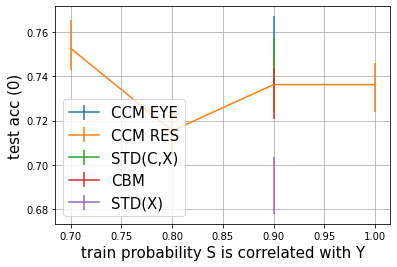

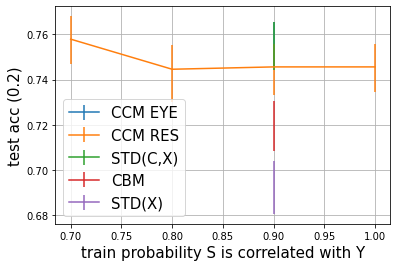

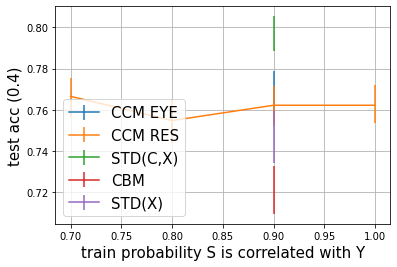

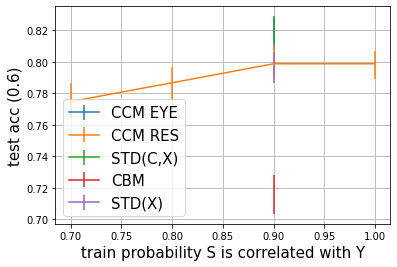

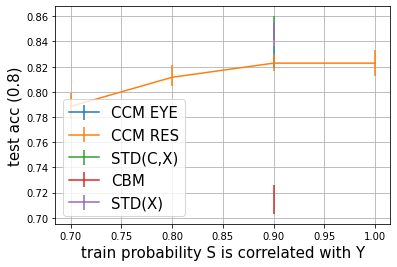

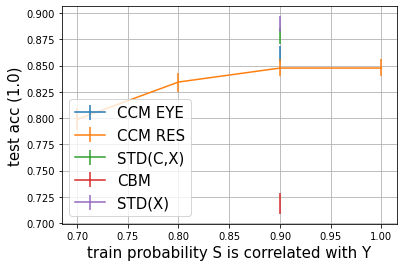

In [38]:
# plot result
def plot_results(results, method_name, key, display_x=lambda x: x):
    x = sorted(results[method_name].keys())
    values = np.array([results[method_name][x_][key] for x_ in x]) # (n, 3)
    y = values[:, 1]
    yerr = np.vstack([y - values[:, 0], values[:, 2] - y])
    x_display = [display_x(x_) for x_ in x]
    plt.errorbar(x_display, y, yerr=yerr, label=method_name)
        
# keys = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
for key in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    xlabel = f"train probability S is correlated with Y"
    plot_results(results, 'CCM EYE', key)
    plot_results(results, 'CCM RES', key)
    plot_results(results, 'STD(C,X)', key)
    plot_results(results, 'CBM', key)
    plot_results(results, 'STD(X)', key)
    plt.ylabel(f'test acc ({key})', fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    # plt.savefig(f'figures/cub_a2_{key}.png')
    plt.show()



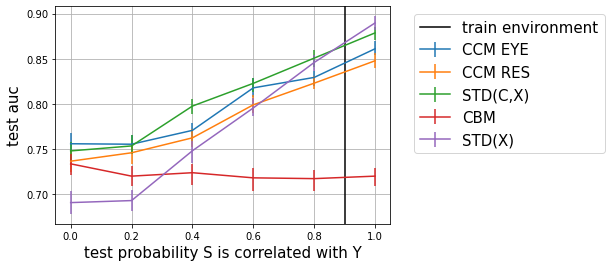

In [39]:
# plot result
def get_results_transpose(results, method_names, keys):
    '''
    change from (keys, train corr) to  (train corr, keys)
    '''
    tresults = {m: defaultdict(dict) for m in method_names} # results[method][x][key]
    for method_name in method_names:
        x = sorted(results[method_name].keys())
        for k in keys:
            for x_ in x:
                tresults[method_name][k][x_] = results[method_name][x_][k]
                
    return tresults

tresults = get_results_transpose(results, methods, [0, 0.2, 0.4, 0.6, 0.8, 1.0])
for key in [0.9]: #[0.7, 0.8, 0.9]:
    xlabel = f"test probability S is correlated with Y"
    plot_results(tresults, 'CCM EYE', key)
    plot_results(tresults, 'CCM RES', key)
    plot_results(tresults, 'STD(C,X)', key)
    plot_results(tresults, 'CBM', key)
    plot_results(tresults, 'STD(X)', key)
    plt.axvline(key, color='k', label="train environment")
    plt.ylabel(f'test auc', fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.legend(fontsize=15, bbox_to_anchor=(1.05, 1))
    plt.grid()
    # plt.savefig(f'figures/cub_a2_tr{key:.2f}.png')
    plt.show()



## Swapping noise (see Q1)

This setting fixes S, but reduces the impact of C; S contain information outside of C, but within U. The C+S models gives 66.4% on biased dataset versus the C model only gives 57.7%. Other results are in relaxSinC.

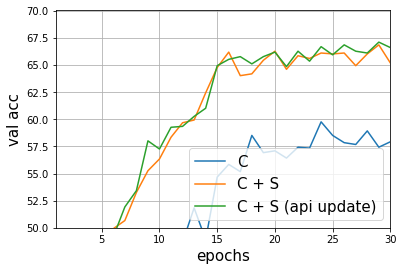

In [50]:
key = 'val acc'
plot_log(torch.load("../outputs/dnoise100/7ef5dec0f45a11ebb773ac1f6b24a434/cbm.log"), key=key, label="C")
plot_log(torch.load("../outputs/relaxSinC/2b477560137a11ecb773ac1f6b24a434/cbm.log"), key=key, label="C + S")
plot_log(torch.load("../outputs/d44f570a14eb11ecb773ac1f6b24a434/cbm.log"), key=key, label="C + S (api update)")

plt.xlim([1, 30])
plt.ylim(50)
plt.grid()
plt.legend(fontsize=15)
plt.ylabel(key)
plt.show()

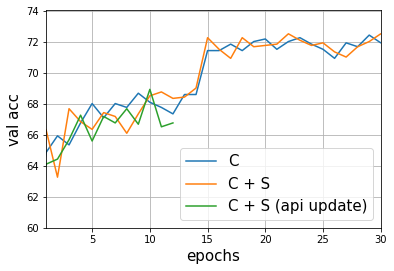

In [51]:
key = 'val acc'
plot_log(torch.load("../outputs/dnoise0/4412083eee9b11ebb773ac1f6b24a434/cbm.log"), key=key, label="C")
plot_log(torch.load("../outputs/relaxSinC/cdc7fd32137f11ecb773ac1f6b24a434/cbm.log"), key=key, label="C + S")
plot_log(torch.load("../outputs/4804b87014f611ecb773ac1f6b24a434/cbm.log"), key=key, label="C + S (api update)")

plt.xlim([1, 30])
plt.ylim(60)
plt.grid()
plt.legend(fontsize=15)
plt.ylabel(key)
plt.show()

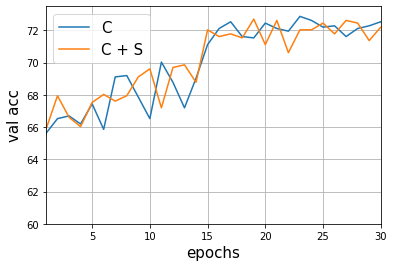

In [46]:
key = 'val acc'
plot_log(torch.load("../outputs/dnoise30/cbcff470f42c11ebb773ac1f6b24a434/cbm.log"), key=key, label="C")
plot_log(torch.load("../outputs/relaxSinC/610ee214138e11ecb773ac1f6b24a434/cbm.log"), key=key, label="C + S")

plt.xlim([1, 30])
plt.ylim(60)
plt.grid()
plt.legend(fontsize=15)
plt.ylabel(key)
plt.show()

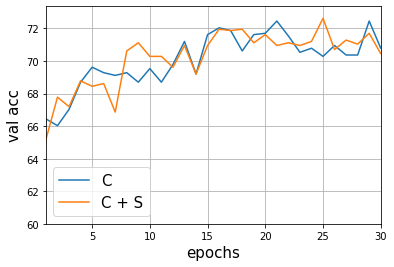

In [47]:
key = 'val acc'
plot_log(torch.load("../outputs/dnoise70/960b7b96f46011ebb773ac1f6b24a434/cbm.log"), key=key, label="C")
plot_log(torch.load("../outputs/relaxSinC/ae27e4dc138511ecb773ac1f6b24a434/cbm.log"), key=key, label="C + S")

plt.xlim([1, 30])
plt.ylim(60)
plt.grid()
plt.legend(fontsize=15)
plt.ylabel(key)
plt.show()

In [4]:
np.corrcoef([[2,3],[1,2]])

array([[1., 1.],
       [1., 1.]])

In [10]:
a = np.random.randn(10)
b = a > 0
c = np.vstack([a,b])
np.corrcoef(c)

array([[1.        , 0.77524935],
       [0.77524935, 1.        ]])